In [1]:
#This script plots FEA and measured cap data with contraction (L)
#Imports the optimized electrode displacement sweep from FEA
#Makes a third order polynomial fit angle xi(C)
#Uses kinematic model linear fit L(xi) to find L(C) from kresling_kinematic notebook
#Analyzes open loop data with capacitance measurement and optitrack
#Plots each set of capacitance and optitrack data vs. time
#Plots each set of capacitance vs. contraction
#Open loop and FEA data are available in OpenLoopData.zip 

import csv
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import bagpy
from tqdm.notebook import tqdm

comsol_file = "comsol_data_80_136.csv"
kinematic_fit = [10.38580026, 0.22017451] #These coefficients are from the kresling_kinematic notebook, zero order first

opti_column = 7 #column in optitrack for displacement axis #set during data collection, do not change for z axis

In [2]:
opti_files = ["take_1.csv", "take_2.csv", "take_3.csv"]
cap_files = ["take_1.bag", "take_2.bag", "take_3.bag"]

opti_starts = [5.2, 3.6, 4.9] #Start time of the test in optitrack data, determined manually 
cap_starts = [10.8, 13.2, 6.1] #Start time of the test in capacitance data, determined manually

In [3]:
def comsol_fit(comsol_file):
    #Read in data from Comsol FEA to calculate sensitivity gain in capacitance
    #Returns linear fit parameters, comsol_data with shape (n,2) of [angle, capacitance], and comsol_length 
    #from first and third order polynomial fits

    comsol_data = np.array([[0,0]])

    with open(comsol_file) as readfile:
        reader = csv.reader(readfile, delimiter=',')
        next(reader)
        for line in readfile:
            values = line.split(',')
            fold_angle = float(values[0])
            cap_comsol = float(values[1]) * 10**12 #convert to pF
            comsol_data = np.append(comsol_data,[[fold_angle, cap_comsol]], axis = 0)


    #Zero capacitance data from the last (smallest) value
    comsol_data = comsol_data[1:,:]
    comsol_data[:,1] = comsol_data[:,1] - min(comsol_data[:,1])
    
    #Find length values from angles and kinematic model
    length_fit = np.polynomial.polynomial.polyval(comsol_data[:,0], kinematic_fit)
    comsol_length = max(length_fit) - length_fit
    
    #Find 3rd order polynomial fit from capacitance to angle xi
    FEA_cap_fit_params = np.polynomial.polynomial.polyfit(comsol_data[:,1], comsol_data[:,0], 3)

    #Fit contracted length to zeroed capacitance using linear fit
    FEA_lin_fit_params = np.polynomial.polynomial.polyfit(comsol_length, comsol_data[:,1], 1)
    
    comsol_data = np.hstack((comsol_data, comsol_length[:, np.newaxis]))
                                                          
    return FEA_lin_fit_params, comsol_data

In [4]:
def convert_mocap(optitrack_file, opti_column, start_time):
    #Reads in optitrack data and converts to time and displacement
    #Returns np array of zeroed data [time, contraction]
    
    opti_data = np.array([[0,0]])

    with open(optitrack_file) as readfile:
        reader = csv.reader(readfile, delimiter=',')
        for i in range(opti_column + 1):
            next(reader)
        for line in tqdm(readfile):
            values = line.strip().split(',')
            if values[opti_column] == '':
                continue
            time_opti = float(values[1])
            disp_opti = float(values[opti_column])
            opti_data = np.append(opti_data, [[time_opti, disp_opti]], axis = 0)

    #Zero and convert displacement to mm
    opti_data_zeroed = opti_data[1:,:]
    opti_data_zeroed[:,0] = opti_data[1:,0] - start_time
    opti_data_zeroed[:,1] = (opti_data[1:,1] - opti_data[1,1])*-1e3

    return opti_data_zeroed


In [5]:
def plot_opti_data(opti_data, opti_file):
    #Plots optitrack data of contraction vs. time for visualization
    
    plt.figure(figsize=(3.5, 2.5),facecolor=(1, 1, 1), tight_layout=True)

    plt.plot(opti_data[:,0], opti_data[:,1], 'b.', markersize = 3, alpha = 1)

    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (mm)')

    plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']
    plt.title('Contraction for file: ' + str(opti_file))
    plt.grid()
    plt.show()
    

In [6]:
def convert_bag(bagfile, start_time):
    #### Read in capacitance data from open loop testing bag file
    #Return zeroed np array [time, cap1, cap2, cap3]

    cap_data = np.array([[0,0,0,0]])

    #Read in messages from bagfile and convert to csv file
    b = bagpy.bagreader(bagfile)
    cap_msgs = b.message_by_topic('/capacitance')

    capacitance_csv = str(bagfile[:-4]+"/capacitance.csv")

    #Read in from csv file
    with open(capacitance_csv) as readfile:
        reader = csv.reader(readfile, delimiter=',')
        next(reader)
        for line in readfile:
            values = line.split(',')
            time_cap = float(values[0]) 
            cap_1 = float(values[5])
            cap_2 = float(values[6])
            cap_3 = float(values[7])
            cap_4 = float(values[8])
            cap_data = np.append(cap_data,[[time_cap, cap_1, cap_3 ,cap_4]], axis=0) #cap2 excluded because channel was not used

    #Zero each channel 
    cap_data_zeroed = cap_data[1:,:]
    cap_data_zeroed[:,0] = cap_data[1:,0] - start_time - cap_data[1,0]
    cap_data_zeroed[:,1] = cap_data[1:,1] - cap_data[1,1]
    cap_data_zeroed[:,2] = cap_data[1:,2] - cap_data[1,2]
    cap_data_zeroed[:,3] = cap_data[1:,3] - cap_data[1,3]

    return cap_data_zeroed

In [7]:
def plot_cap_data(cap_data, cap_file):
    #Plots capacitance vs. time on each sensor channel and the mean
    
    plt.figure(figsize=(3.5,2.5),facecolor=(1, 1, 1),tight_layout=True)

    plt.plot(cap_data[:,0], cap_data[:,1], 'b.', markersize = 3, alpha = 1)
    plt.plot(cap_data[:,0], cap_data[:,2], 'g.', markersize = 3, alpha = 1)
    plt.plot(cap_data[:,0], cap_data[:,3], 'k.', markersize = 3, alpha = 1)
    #plt.plot(cap_data[:,0], np.mean(cap_data[:,1:],axis=0), 'c.', markersize = 3, alpha = 1)

    plt.xlabel('Time (s)')
    plt.ylabel('\Delta Capacitance (pF)')

    plt.legend(['C1', 'C3', 'C4', 'Mean'])
    
    plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']
    
    plt.title('Capacitance for file: ' + str(cap_file))
    plt.ylim([-0.1,1])
    plt.grid()
    plt.show()

In [8]:
def sync_datas(opti_data, cap_data):
    #Sync optitrack and capacitance data in time
    #Returns np array sync_data [contraction, cap1, cap2, cap3]

    sync_data = np.array([[0,0,0,0]])
    end_time = 35 #End data set this far into test
    
    start_index_cap =  np.argmin(abs(cap_data[:,0]))
    end_index_cap = np.argmin(abs(cap_data[:,0] - end_time))
    
    for index_cap in range(end_index_cap - start_index_cap):
        index_opti = np.argmin(abs(opti_data[:,0] - cap_data[index_cap + start_index_cap, 0])) #find the closest index for each time in time_cap
        
        if index_opti > 0:
            sync_disp = (opti_data[index_opti,1])
            sync_cap1 = (cap_data[index_cap + start_index_cap, 1])
            sync_cap2 = (cap_data[index_cap + start_index_cap, 2])
            sync_cap3 = (cap_data[index_cap + start_index_cap, 3])
            sync_data = np.append(sync_data,[[sync_disp, sync_cap1, sync_cap2, sync_cap3]], axis=0)
            
    return sync_data[1:,:]

In [9]:
def plot_final(synced_data, comsol_data, save_name):
    #The plot thickens
    
    plt.figure(figsize=(3.5, 2),facecolor=(1, 1, 1),tight_layout=True)
    cap_mean = np.mean([synced_data[:,1], synced_data[:,2], synced_data[:,3]], axis = 0)

    plt.plot(comsol_data[:,2], comsol_data[:,1], 'b', linewidth=2)
    plt.plot(synced_data[:,0], synced_data[:,1], 'k.')
    plt.plot(synced_data[:,0], synced_data[:,2], 'g.')
    plt.plot(synced_data[:,0], synced_data[:,3], 'c.')
    plt.plot(synced_data[:,0], cap_mean, 'm.')
    plt.grid('True')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 9
    BIGGER_SIZE = 9

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    plt.legend(['FEA', 'S0', 'S1', 'S2', 'Avg'])

    plt.xlabel('Contraction (mm)')
    plt.ylabel('$\Delta$ Capacitance (pF)')

    plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans',
                                   'Lucida Grande', 'Verdana']

    plt.savefig(save_name, dpi=600, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

    plt.show()

0it [00:00, ?it/s]

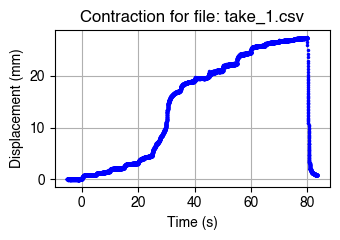

[INFO]  Successfully created the data folder take_1.


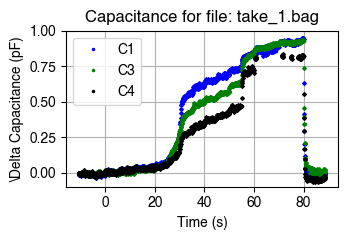

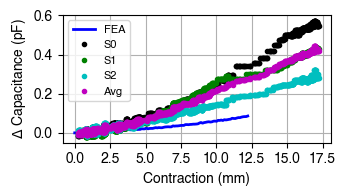

0it [00:00, ?it/s]

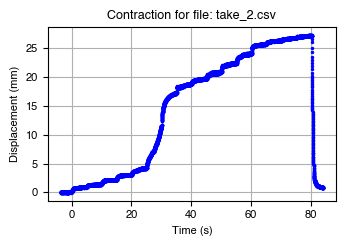

[INFO]  Successfully created the data folder take_2.


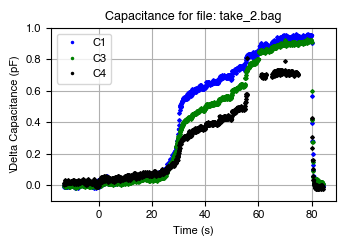

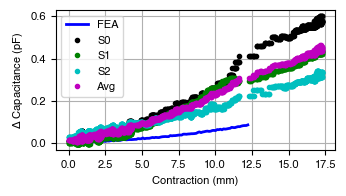

0it [00:00, ?it/s]

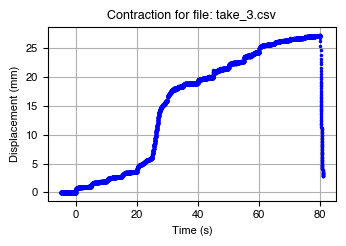

[INFO]  Successfully created the data folder take_3.


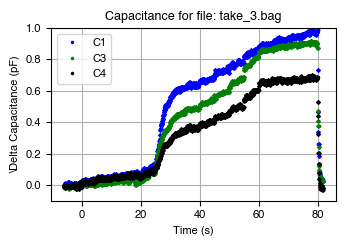

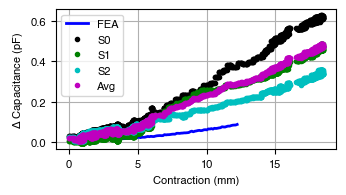

The FEA scale factor is [0.261, 0.262, 0.259]
The average FEA scale factor is 0.261


In [10]:
kappa = [] #Measured capacitance to FEA capacitance scale factor
FEA_lin_fit_params, comsol_data = comsol_fit(comsol_file)

for files in range(len(opti_files)):

    opti_file = opti_files[files]
    opti_data = convert_mocap(opti_file, opti_column, opti_starts[files])
    plot_opti_data(opti_data, opti_file)
    
    cap_file = cap_files[files]
    cap_data = convert_bag(cap_file, cap_starts[files])
    plot_cap_data(cap_data, cap_file)
    
    synced_data = sync_datas(opti_data, cap_data)
    
    #fit to the mean of each set of capacitance measurements

    cap_mean = np.mean([synced_data[:,1],synced_data[:,2],synced_data[:,3]], axis=0)
    cap_fit_params = np.polynomial.polynomial.polyfit(synced_data[:,0], cap_mean , 1)
    cap_fit_line = np.polynomial.polynomial.polyval(synced_data[:,0], cap_fit_params)
    
    synced_data = np.hstack((synced_data, cap_fit_line[:, np.newaxis]))
    
    kappa.append(round(FEA_lin_fit_params[1]/cap_fit_params[1],3)) #divide slopes of two plots
    
    plot_final(synced_data, comsol_data, opti_file[:-4])

print("The FEA scale factor is " + str(kappa)) 
print("The average FEA scale factor is " + str(round(np.mean(np.array([kappa])),3)))
